# Seasonal box plots.
  Create box plots for all seasons and stations. 

## Function to create season errors.

In [3]:
from METCOMP_utils import *
import matplotlib.pyplot as plt
import matplotlib
import datetime
import numpy as np
import pandas as pd
import calendar

# Creates a dataframe with the error in each datapoint for given seasons and 
# years. OBS. Reads both SMHI and LantMet data from .csv file.
# @params stationId: station id as a string.
#         param: weather parameter as a string.
#                'TM' - temperature (2m)
#                'UM' - relative humidity
#                'RR' - precipitation
#                'FM2' - wind speed
#         start_year: start year given as an integer.
#         end_year: end year given as an integer.
#         season: season as string, 'spring','summer','fall' or 'winter'
# @returns df_ERROR: concatenated dataframe with the error each hour from the 
#                    given months and years.
def season_error(stationId, param, start_year, end_year, season):
    
    if season == 'Spring':
        start_month = 3
        end_month = 5 
    elif season == 'Summer':
        start_month = 6
        end_month = 8 
    elif season == 'Fall':
        start_month = 9
        end_month = 11 
    elif season == 'Winter':
        start_month = 12
        end_month = 2

    start_day = 1
    end_day = calendar.monthrange(end_year, end_month)[1]   
    df_LANTMET = pd.DataFrame()
    df_MESAN = pd.DataFrame()
    current_year = start_year

    # Read data from CSV to dataframes
    print('Loading data...')
    for i in range(0, end_year - start_year + 1):
        start_date = datetime.date(current_year, start_month, start_day)

        if end_month < start_month:
            end_date = datetime.date(current_year + 1, end_month, end_day)
        else:
            end_date = datetime.date(current_year, end_month, end_day)

        df_LANTMET = df_LANTMET.append(read_CSV(stationId, 'LANTMET', start_date, end_date))
        df_MESAN = df_MESAN.append(read_CSV(stationId, 'MESAN', start_date, end_date))
        current_year = current_year + 1

    # Translation dictionary from LANTMET designations to MESAN designations.
    param_dict = {'TM': 't', 'RR': 'prec1h', 'UM': 'r', 'FM2': 'ws'}

    # Unit conversion if needed.
    if param == 'UM':
        df_MESAN[param_dict[param]] = df_MESAN[param_dict[param]]*100

    # Check for missing values. Remove from both datasets.
    print('Checking for missing values...')
    bad_rows = {}
    bad_MESAN = df_MESAN[df_MESAN[param_dict[param]].isnull()]
    bad_LANTMET = df_LANTMET[df_LANTMET[param].isnull()]
    # Find rows
    for index, df_row in bad_MESAN.iterrows():
        bad_rows[df_row['Timestamp']] = None
    for index, df_row in bad_LANTMET.iterrows():
        bad_rows[df_row['Timestamp']] = None
    # Remove rows.
    for bad_row in bad_rows:
        print('Found NaN value at ' + bad_row + '. Removing from both datasets.', end='\n')
        df_MESAN = df_MESAN[~df_MESAN['Timestamp'].str.contains(bad_row)]
        df_LANTMET = df_LANTMET[~df_LANTMET['Timestamp'].str.contains(bad_row)]

    # Construct error dataframe.
    timestamps = df_MESAN['Timestamp'].to_numpy()
    errors = abs(df_MESAN[param_dict[param]].to_numpy() - df_LANTMET[param].to_numpy())
    df_ERROR = pd.DataFrame.from_dict({'Timestamp': timestamps, 'Error': errors})

    return df_ERROR

## Create box plots.
Specify parameter: 
'TM' - temperature (2m),
'UM' - relative humidity,
'RR' - precipitation,
'FM2' - wind speed.

Loading data...
Checking for missing values...
Loading data...
Checking for missing values...
Loading data...
Checking for missing values...
Loading data...
Checking for missing values...
Loading data...
Checking for missing values...
Loading data...
Checking for missing values...
Loading data...
Checking for missing values...
Loading data...
Checking for missing values...


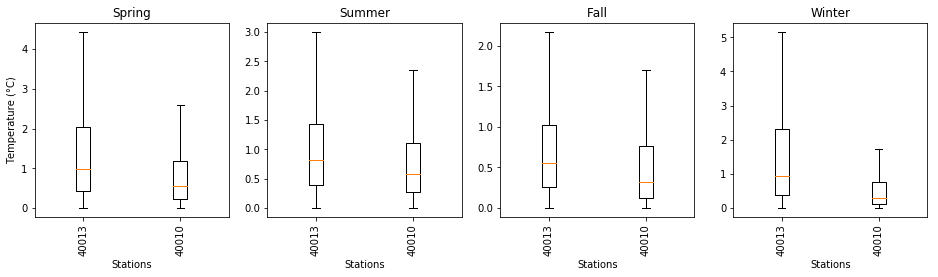

In [2]:
# Choose parameter, start year and end year
param = 'TM'
start_year = 2017
end_year = 2019

stationId_list = ['40013', '40010']#, '25754', '40003', '24768', '40005', '23470', '25786', '24856', '23658', '40004', '23659', '25652', '20949', '40145', '40007', '40143', '22234']
season_list =['Spring', 'Summer', 'Fall', 'Winter']

df_ERROR_all = {}
# Loop over all seasons
for season in season_list:
    df_ERROR_all[str(season)] = {}

    # Loop over all stations 
    for stationId in stationId_list:
        df_ERROR = season_error(stationId, param, start_year, end_year, str(season))
        df_ERROR_all[str(season)][str(stationId)] = df_ERROR

# Create boxplots for all seasons
fig, axs = plt.subplots(1, 4, figsize=(16, 16))

for season in season_list:
    data = list()
    labels = list()

    for i in range(0,len(stationId_list)):
        data.append(df_ERROR_all[str(season)][str(stationId_list[i])]['Error'])
        labels.append(stationId_list[i])

    axs[season_list.index(str(season))].boxplot(data, labels=labels, showfliers=False)
    axs[season_list.index(str(season))].set_xlabel('Stations')
    if param == 'TM' and season == 'Spring':
         axs[season_list.index(str(season))].set_ylabel('Temperature (°C)')
    elif param == 'RR' and season == 'Spring':
        axs[season_list.index(str(season))].set_ylabel('Precipitation (mm)')
    elif param == 'FM2' and season == 'Spring':
        axs[season_list.index(str(season))].set_ylabel('Wind speed (m/s)')
    elif param == 'UM' and season == 'Spring':
        axs[season_list.index(str(season))].set_ylabel('Humidity (%)')
    axs[season_list.index(str(season))].set_title(str(season))
    x0,x1 = axs[season_list.index(str(season))].get_xlim()
    y0,y1 = axs[season_list.index(str(season))].get_ylim()
    axs[season_list.index(str(season))].set_aspect(abs(x1-x0)/abs(y1-y0))
    axs[season_list.index(str(season))].set_xticklabels(labels, rotation=90)